In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Modelo predictivo de Up-selling

## Data Exploration

### Declaración de DataFrames globales

- **df_ventas_csv** : todo el fichero de VENTAS.TXT
- **df_clientes_csv** : todo el fichero de CLIENTES.TXT.
- **df_sectores_csv** : todo el fichero SECTORES.TXT
- **df_compras_usuario_producto_agg** : agregado de numero de compras y e importe de ventas por usuario y producto, sobre el df_ventas_csv.
- **df_rfm** : extracción de variables rfm para df_ventas_csv.
- **df_rfm_no_outliers** : df_rfm eliminando atípicos.
- **df_rfm_scaled** : escalado gaussiano de df_rfm_no_outliers.
- **df_labels** : dimension con los indices de los clusters, su descripción corta y larga.
- **df_rfm_with_label** : mezcla de df_rfm_no_outliers y df_labels. Contiene los IDs de los clientes utilizados para el RFM, así como la clase asignada.
- **df_ventas_rfm** : cruce de df_ventas_csv con df_rfm_with_label
- **df_clientes_csv_rfm_with_label** : clientes de df_clientes_csv, filtrados a aquellos que se encuentran en df_rfm_with_labels.


### Fichero de Ventas

In [3]:
df_ventas_csv = pd.read_csv("data/VENTAS.TXT", sep="|", header=0)

In [4]:
df_ventas_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20537 entries, 0 to 20536
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                20537 non-null  int64 
 1   FECHAVENTA        20537 non-null  object
 2   PRODUCTOCOMPRADO  20537 non-null  object
 3   CANALVENTA        20537 non-null  object
 4   IMPORTE           20537 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 802.4+ KB


In [5]:
df_ventas_csv.head()

,ID,FECHAVENTA,PRODUCTOCOMPRADO,CANALVENTA,IMPORTE
0,6389279,21/3/2017 0:00:00,VP Informe,WEB,22
1,6389989,21/3/2017 0:00:00,VP Informe,WEB,15
2,6329507,1/2/2017 0:00:00,VP Informe,WEB,35
3,6326580,1/2/2017 0:00:00,VP Informe,WEB,22
4,6326580,1/2/2017 0:00:00,VP Informe,WEB,22


El fichero de compras tiene 4 variables:
- **ID**: Id único del cliente (numérico)
- **FECHAVENTA**: fecha de la venta (fecha)
- **PRODUCTOCOMPRADO**: el producto en concreto comprado (categorico)
- **CANALVENTA**: canal de la vetna (categórico)
- **IMPORTE**: importe de la venta (númerico)

**Expandimos variable de tipo fecha**

In [6]:
df_ventas_csv['FECHAVENTA'] = pd.to_datetime(df_ventas_csv['FECHAVENTA'], format='%d/%m/%Y %H:%M:%S')
df_ventas_csv['dia_venta'] = df_ventas_csv['FECHAVENTA'].dt.day
df_ventas_csv['mes_venta'] = df_ventas_csv['FECHAVENTA'].dt.month
df_ventas_csv['anio_venta'] = df_ventas_csv['FECHAVENTA'].dt.year

**Convertimos tipos**

In [9]:
df_ventas_csv['ID'] = df_ventas_csv['ID'].astype(str).str.strip()

In [10]:
df_ventas_csv.describe()

,FECHAVENTA,IMPORTE,dia_venta,mes_venta,anio_venta
count,20537,20537.000000,20537.000000,20537.000000,20537.000000
mean,2020-08-05 08:30:44.086283264,77.900521,16.019867,6.578176,2020.090081
min,2017-01-02 00:00:00,6.000000,1.000000,1.000000,2017.000000
25%,2019-04-03 00:00:00,15.000000,8.000000,4.000000,2019.000000
50%,2020-10-14 00:00:00,35.000000,16.000000,7.000000,2020.000000
75%,2022-01-06 00:00:00,65.000000,24.000000,9.000000,2022.000000
max,2023-07-27 00:00:00,4875.000000,31.000000,12.000000,2023.000000
std,NaN,200.632042,8.719892,3.287639,1.708633


In [11]:
df_ventas_csv.select_dtypes(include='object').describe()

,ID,PRODUCTOCOMPRADO,CANALVENTA
count,20537,20537,20537
unique,9512,3,2
top,8125558,VP Informe,WEB
freq,173,18020,18478


In [12]:
print(df_ventas_csv.PRODUCTOCOMPRADO.unique())

['VP Informe' 'Plan' 'Bono']


In [13]:
print(df_ventas_csv.CANALVENTA.unique())

['WEB' 'CALLCENTER']


Búsqueda de Nulos

In [14]:
df_ventas_csv.isna().sum()

ID                  0
FECHAVENTA          0
PRODUCTOCOMPRADO    0
CANALVENTA          0
IMPORTE             0
dia_venta           0
mes_venta           0
anio_venta          0
dtype: int64

No hay nulos

**Análisis estadístico básico**

**PRODUCTOCOMPRADO**

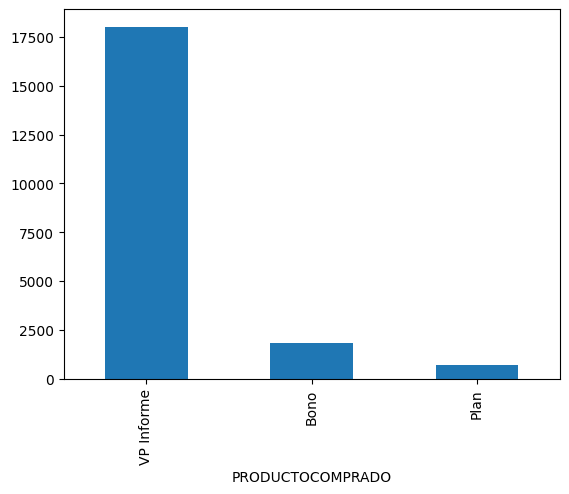

In [15]:
df_ventas_csv.PRODUCTOCOMPRADO.value_counts().plot(kind="bar");

- Se observa que el producto más vendido es, con diferencia, el **informe puntual**. Asumimos que los **bonos** y **planes** son más caros (ahora lo analizaremos) y por eso se venden menos, aunque deben representar a clientes más fieles. Aunque también puede suceder que tengamos clientes que gastan mucho en informes puntuales y que sean igual de fieles que los compradores de planes o bonos.

**IMPORTE**

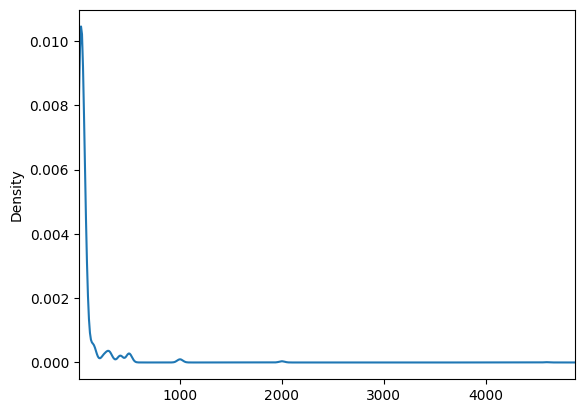

In [16]:
df_ventas_csv["IMPORTE"].plot(kind="density", xlim=(df_ventas_csv["IMPORTE"].min(),df_ventas_csv["IMPORTE"].max()));

In [17]:
df_ventas_csv["IMPORTE"].describe(percentiles=[.25, .5, .75, .90, .95, .99])

count    20537.000000
mean        77.900521
std        200.632042
min          6.000000
25%         15.000000
50%         35.000000
75%         65.000000
90%        150.000000
95%        300.000000
99%       1000.000000
max       4875.000000
Name: IMPORTE, dtype: float64

- El 90% de las ventas está por debajo de 150 pesos y la mitad, por debajo de 35 pesos.
- La mayor parte de las compras son de bajo importe.
- Tenemos algunas compras de altísimo valor con respecto al comportamiento normal.

**Importe por producto**

**VP Informe**

In [18]:
df_ipp = df_ventas_csv[df_ventas_csv.PRODUCTOCOMPRADO=="VP Informe"]["IMPORTE"]
df_ipp.describe()

count    18020.000000
mean        33.923585
std         19.514838
min          6.000000
25%         15.000000
50%         35.000000
75%         40.000000
max        110.000000
Name: IMPORTE, dtype: float64

- Los informes varían entre 6 y 110 pesos de precio.

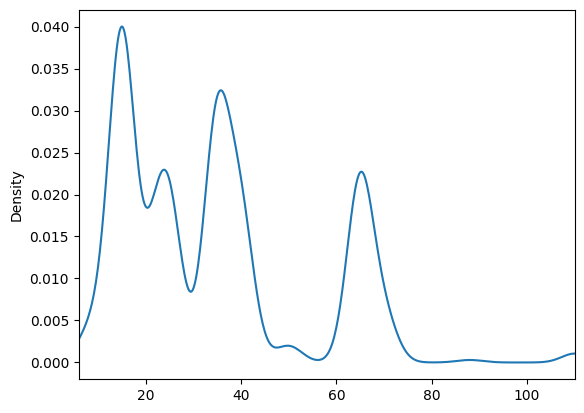

In [19]:
df_ipp.plot(kind="density", xlim=(df_ipp.min(),df_ipp.max()));

- El importe de las Ventas Puntuales de informe está sesgado hacia la izquierda. Los compradores tienen tendencia a comprar informes más económicos, aunque se aprecia una distribución multimodal, con varios picos. Puede que haya varios tipos de compradores de VP.

**Plan**

In [20]:
df_ipp = df_ventas_csv[df_ventas_csv.PRODUCTOCOMPRADO=="Plan"]["IMPORTE"]
df_ipp.describe()

count    710.000000
mean     322.804225
std       90.868508
min       69.000000
25%      252.000000
50%      330.000000
75%      414.000000
max      414.000000
Name: IMPORTE, dtype: float64

- Los planes varían entre 69 y 414 pesos

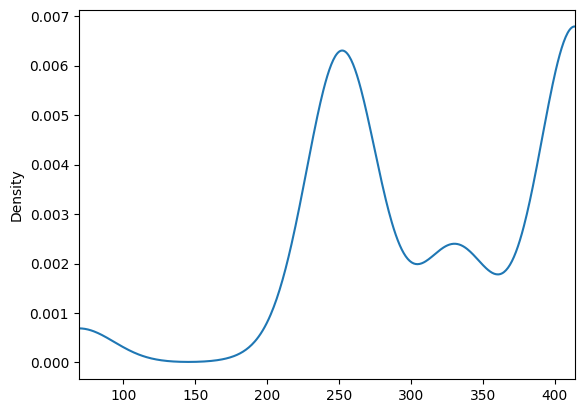

In [21]:
df_ipp.plot(kind="density", xlim=(df_ipp.min(),df_ipp.max()));

- La distribución de los importes de venta es claramente multimodal con un pico sobre los 250 y otro en los 400.

**Bono**

In [22]:
df_ipp = df_ventas_csv[df_ventas_csv.PRODUCTOCOMPRADO=="Bono"]["IMPORTE"]
df_ipp.describe()

count    1807.000000
mean      420.226342
std       539.026418
min        14.000000
25%       150.000000
50%       300.000000
75%       500.000000
max      4875.000000
Name: IMPORTE, dtype: float64

- Los precios de los bonos varían mucho, entre 14 pesos y 4875 pesos

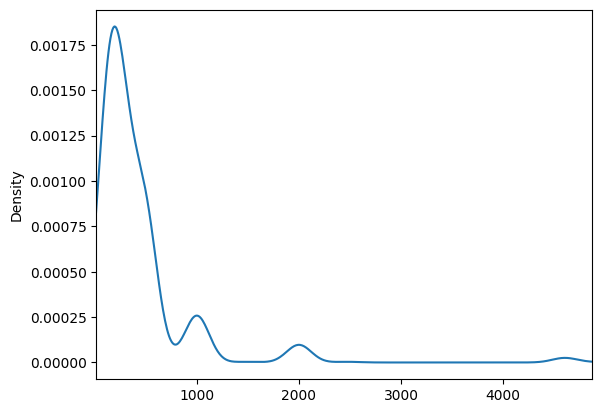

In [23]:
df_ipp.plot(kind="density", xlim=(df_ipp.min(),df_ipp.max()));

- Claramente, los compradores tienen tendencia a comprar bonos más enconómicos, aunque vemos algunos picos en bonos de mucho mayor importe (1000, 2000 e incluso por encima de 4000). También podemos tener distintos tipos de comprador de bonos.

**Comparativa de la distribución de los importes de venta de los tres productos**

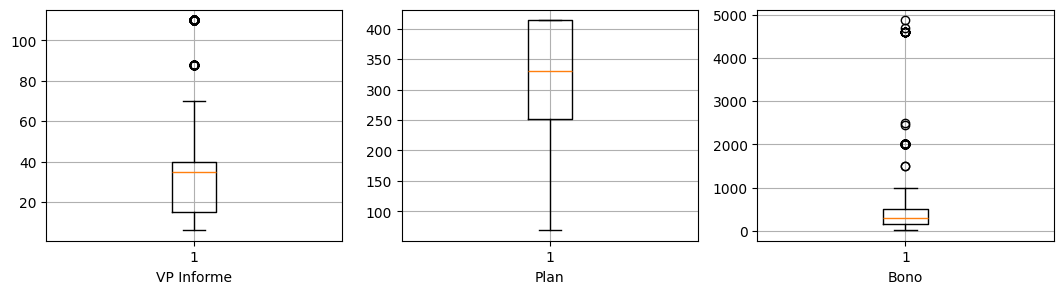

In [24]:
categories = df_ventas_csv["PRODUCTOCOMPRADO"].unique()

fig, axes = plt.subplots(nrows=1, ncols=len(categories), figsize=(13, 3), sharey=False)

for ax, category in zip(axes, categories):
    subset = df_ventas_csv[df_ventas_csv['PRODUCTOCOMPRADO']==category]
    ax.boxplot(subset['IMPORTE'])
    ax.set_xlabel(category)
    ax.grid(True)

Conclusiones
- La frecuencia y los rangos de venta de los productos son **muy distintos**.
- El comportamiento de los compradores de **Plan y Bono es más similiar**, salvo por los compradores de Bonos de muy alto precio.
- Las diferentes tipologías de producto hacen que el **número de compras por usuario resulte ambiguo**, ya que un usuario que compra un plan de 400 pesos puede realizar sólo un pago, pero sin embargo, ser un cliente muy fiel por importe. 
- Las distribuciones claramente **multimodales** de VP y Plan sugieren que tal vez hay diferentes grupos de compra en cada uno de ellos.

**CANALVENTA**

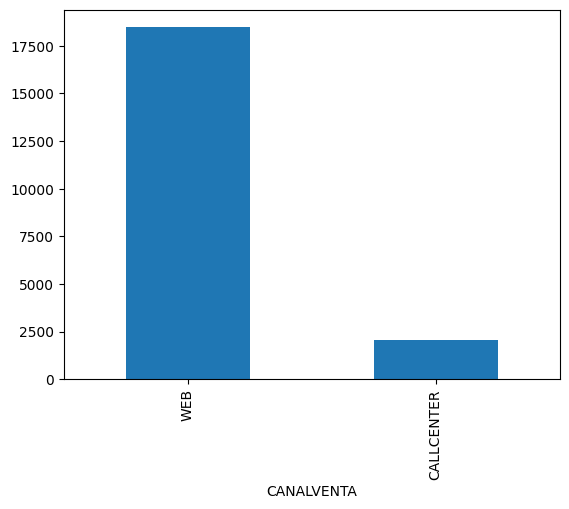

In [25]:
df_ventas_csv.CANALVENTA.value_counts().plot(kind="bar");


- La mayoría de las compras son online. Aquí tenemos dos métodos de compra muy diferentes y tal vez tengamos un patrón de compra aquí.

Histogramas

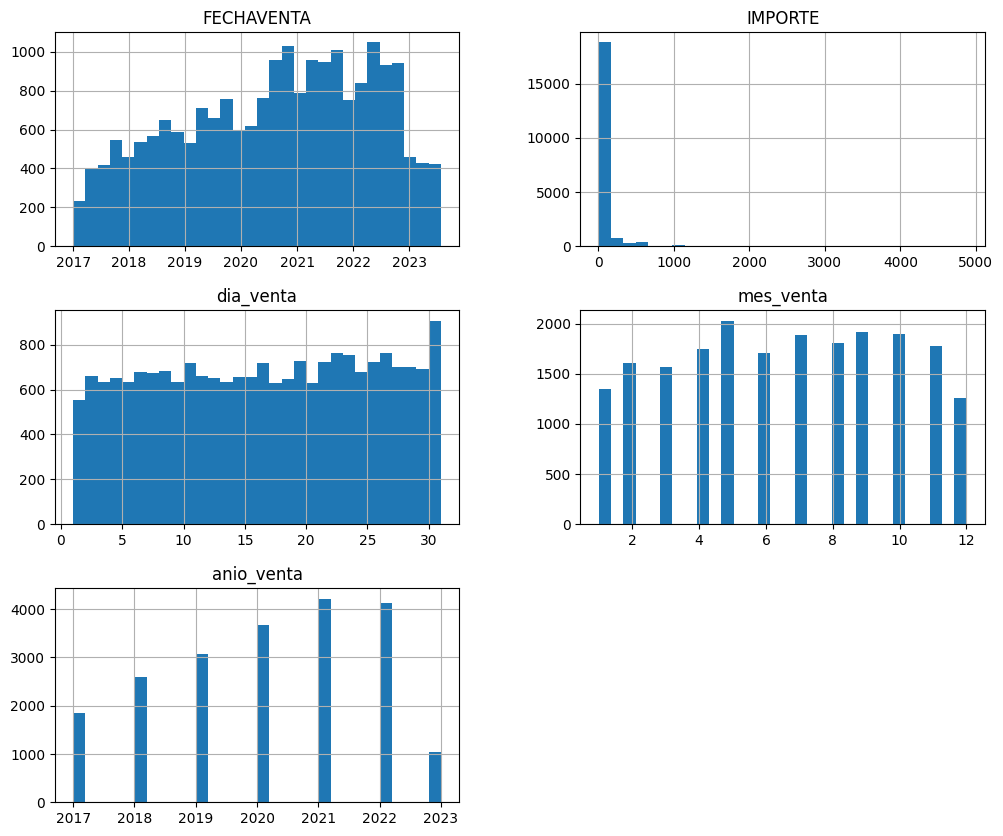

In [26]:
df_ventas_csv.hist(figsize=(12,10), bins=30);

- Sólo hay datos de ventas hasta julio 23.
- Las ventas han ido incrementando con los años hasta 2021 y luego se mantienen.
- No se aprecia patrón de venta sesgado por día o mes de venta, salvo que el día 31 hay un pico de ventas.

**Análisis de compras por usuario**

Contruimos los datos

In [27]:
# Creamos el agregado por usuario y producto comprado
df_compras_usuario_producto_agg = df_ventas_csv.groupby(["ID","PRODUCTOCOMPRADO"]).agg(
        numero_compras=('ID', 'count'),
        total_importe_compra=('IMPORTE', 'sum')
    ).reset_index()

# Extraemos los tipos de producto
categories = df_compras_usuario_producto_agg["PRODUCTOCOMPRADO"].unique()

In [28]:
def plot_dist_compras_usuario(df, kpi, color):

    fig, axes = plt.subplots(nrows=1, ncols=len(categories), figsize=(9, 3), sharey=False)
    
    for i, ax in enumerate(axes):
        ax.hist(df[df["PRODUCTOCOMPRADO"]==categories[i]]
                [kpi], bins=30, color=color)
        ax.set_xlabel(categories[i])
        ax.grid(True)
    
    fig.suptitle(kpi);
    plt.tight_layout(rect=[0, 0, 1, 0.95])

**Distribución de los datos por Número de Compras**

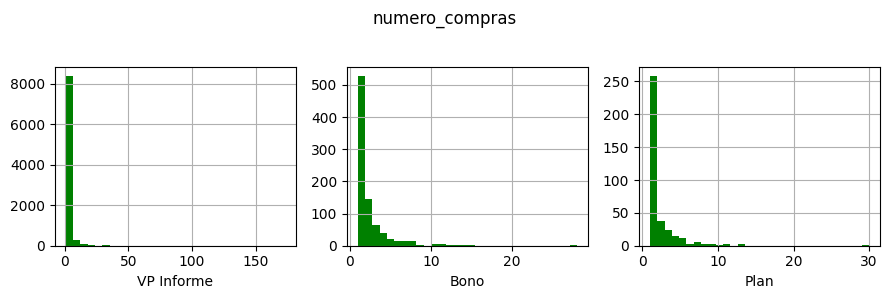

In [29]:
plot_dist_compras_usuario(df_compras_usuario_producto_agg, "numero_compras", "green")

- La distribución por número de compras es **similar** en los tres productos ya que se inclina hacia el 1.
- Sin embargo, parece que haya  **compras más repetitivas en los bonos y planes (cola por la derecha)**, implicando mayor grado de fidelización en estos productos.

Imprimimos el histograma de los datos, para verificar las impresiones visuales

In [30]:
def plot_hist(df, kpi):
    df_hist = pd.DataFrame(columns=(["min","25%", "50%", "75%", "90%", "95%", "99%", "max"]))

    for category in categories:
        p = df[df["PRODUCTOCOMPRADO"]==category][kpi]\
            .describe(percentiles=[.25, .5, .75, .90, .95, .99])
        df_hist.loc[category] = (p["min"], p["25%"], p["50%"], p["75%"], p["90%"], p["95%"], p["99%"], p["max"])

    return df_hist

In [31]:
plot_hist(df_compras_usuario_producto_agg, "numero_compras")

,min,25%,50%,75%,90%,95%,99%,max
VP Informe,1.0,1.0,1.0,2.0,4.0,6.0,14.0,173.0
Bono,1.0,1.0,1.0,2.0,4.0,7.0,11.0,28.0
Plan,1.0,1.0,1.0,2.0,4.0,6.0,11.0,30.0


- Nos estaba engañando la escala de los gráficos. La distribución del número de compras es prácticamente igual en los tres productos, salvo por los máximos en VP Informe.

**Distribución de los datos por Total Importe de Compra**

In [ ]:
plot_dist_compras_usuario(df_compras_usuario_producto_agg, "total_importe_compra", "orange")

- De nuevo, los tres productos tienen a la mayoría de las compras en importes bajos.
- Sin embargo, vemos de nuevo en bonos y planes algo de tendencia a comprar con importes superiores dentro de cada categoría.

Imprimimos el histograma de los datos, para verificar las impresiones visuales

In [ ]:
plot_hist(df_compras_usuario_producto_agg, "total_importe_compra")

- Podemos verificar parcialmente lo visualizado. En los VPs, el mínimo (6) y el 50% (35) son 5 veces más; sin embargo, en Bono, el mínimo (14) y el 50% (300) está a 20 veces. En Planes no pasa lo mismo, el 50% (414) es tan sólo 6 veces más que el mínimo (69)

**Análisis de atípicos**

In [ ]:
def get_outliers_metadata(df):
    '''
    Devuelve un análisis de outliers para todas las columnas numéricas del df
    '''

    outlier_metadata = pd.DataFrame(columns=["Q1", "Q3", "IQR", "upper_bound", "total_outliers", "perc_outliers"])

    #subset = df[df["PRODUCTOCOMPRADO"]==category]
    
    for columna in df.select_dtypes(include=['number']).columns:
    
        # Cálculo de cuartiles y límite de outliers
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + (1.5 * IQR)
    
        # Obtención de los atípicos
        total_outliers = df[df[columna]>upper_bound].shape[0]
        perc_outliers = round(total_outliers/df.shape[0]*100,1)
    
        outlier_metadata.loc[columna] = (Q1, Q3, IQR, upper_bound, total_outliers, perc_outliers)

    return outlier_metadata

**VP Informe**

In [ ]:
producto = df_compras_usuario_producto_agg[df_compras_usuario_producto_agg["PRODUCTOCOMPRADO"]=="VP Informe"]

outliers = get_outliers_metadata(producto)

outliers

- Según la distribución de compras, los usuarios que han comprado más de 3 veces son atípicos. Y si han gastado más de 152.5 pesos también. 
- El porcentaje de atípicos ronda el 10%

**Plan**

In [ ]:
producto = df_compras_usuario_producto_agg[df_compras_usuario_producto_agg["PRODUCTOCOMPRADO"]=="Plan"]

outliers = get_outliers_metadata(producto)

outliers

- Según la distribución de compras, los usuarios que han comprado más de 3 veces son atípicos (igual que en los VPs). Y si han gastado más de 1077 pesos también.
- El porcentaje de atípicos ronda el 13%

**Bonos**

In [ ]:
producto = df_compras_usuario_producto_agg[df_compras_usuario_producto_agg["PRODUCTOCOMPRADO"]=="Bono"]

outliers = get_outliers_metadata(producto)

outliers

- De nuevo, los usuarios que han comprado más de 3 veces son atípicos. Este patrón se repite en los tres tipos de productos. El comportamiento es muy homogeneo.
- En el límite de gasto para ser atípico, los bonos son muy semejantes a los Planes.
- El porcentaje de atípicos es muy similar en los tres productos.

**Análisis visual de atípicos**

In [ ]:
def print_outlier_visual_analysis(df, kpi):

    categories = df["PRODUCTOCOMPRADO"].unique()
    
    fig, axes = plt.subplots(nrows=1, ncols=len(categories), figsize=(13, 3), sharey=False)
    
    for ax, category in zip(axes, categories):
        subset = df[df['PRODUCTOCOMPRADO']==category]
        ax.boxplot(subset[kpi])
        ax.set_xlabel(category)
        ax.grid(True)
    
    fig.suptitle(kpi)

In [ ]:
print_outlier_visual_analysis(df_compras_usuario_producto_agg, 'numero_compras')

Por número de compras, ya sabíamos que la mayoría de los compradores repiten poco. Sin embargo, los repetidores en los tres productos no parecen datos erroneos. 

In [ ]:
print_outlier_visual_analysis(df_compras_usuario_producto_agg, 'total_importe_compra')

- Para VPs, se ven datos muy alejados. Podría ser sospecho. Aunque al ser varios compradores, no apunta a dato erroneo.
- Para Planes pasa lo mismo, pero no parecen varios datos. Lo revisaremos.
- En Bono no se aprecia un patrón de datos erroneos.

Revisión de atípicos de Planes

In [ ]:
df_planes =  df_compras_usuario_producto_agg[df_compras_usuario_producto_agg['PRODUCTOCOMPRADO']=="Plan"]["total_importe_compra"]

#Filtramos para el percetil 99 de atípicos de Planes
df_planes_outlier = df_planes[df_planes>4130.25]

df_planes_outlier.sort_values()

Hay un único dato especialmente elevado. Habrá que tenerlo presente por si fuera un error de datos

### Fichero de Clientes

In [ ]:
df_clientes_csv = pd.read_csv("data/CLIENTES.TXT", sep="|", header=0)

**Transformación de tipos y set index**

In [ ]:
df_clientes_csv['ID'] = df_clientes_csv['ID'].astype(str).str.strip()
df_clientes_csv = df_clientes_csv.set_index("ID")
df_clientes_csv['FECHA_REGISTRO'] = pd.to_datetime(df_clientes_csv['FECHA_REGISTRO'], format='%d/%m/%Y %H:%M:%S')
df_clientes_csv['FECHA_CLIENTE'] = pd.to_datetime(df_clientes_csv['FECHA_CLIENTE'], format='%d/%m/%Y %H:%M:%S')

In [ ]:
df_clientes_csv.info()

In [ ]:
df_clientes_csv.head()

**Filtramos los clientes categorizados en el RFM y les asignamos la clase**

In [ ]:
# df_clientes_csv_rfm_with_label = df_clientes_csv.join(df_rfm_with_label[["class","class_desc_short"]], how="inner")

In [ ]:
df_clientes_csv.head()

**Check nulos**

In [ ]:
df_clientes_csv.isna().sum()

Solo encontramos nulos en DEPARTAMENTO, TAMAÑO y ANTIGUEDAD. Los trataremos individualmente.

**FECHA_REGISTRO**
- Fecha en la que se registra el usuario en la web. No tiene por qué ser en la que se convierte en cliente: realiza una compra.

In [ ]:
print(df_clientes_csv["FECHA_REGISTRO"].min())
print(df_clientes_csv["FECHA_REGISTRO"].max())

- No se observan valores fuera de rango. Variable OK.

**CANAL_REGISTRO**
- Canal por el que fue captado el usuario

In [ ]:
df_clientes_csv["CANAL_REGISTRO"].value_counts()

- No se observan valores extraños. Variable OK

**FECHA_CLIENTE**
- Fecha de la primera compra

In [ ]:
print(df_clientes_csv["FECHA_REGISTRO"].min())
print(df_clientes_csv["FECHA_REGISTRO"].max())

- No se observan valores fuera de rango. Variable OK.
- Los valores son coherentes con la FECHA_REGISTRO. El mínimo de fecha cliente es igual al de fecha registro. Sucede igual con el máximo.

**CLIENTEPORCAMPAÑAEMAIL**

1 - Compró por una Campaña de Email

In [ ]:
df_clientes_csv["CLIENTEPORCAMPAÑAEMAIL"].value_counts()

- El 9% de los clientes compró por una campaña de email

**FORMAJURIDICA**
- Forma Societaria de la Empresa/Persona:
    - ADMINISTRACION
    - EMBAJADAS Y ORGANISMOS INTERNACIONALES
    - EMPRESARIO
    - ESAL, Empresa sin Ánimo de Lucro
    - PERSONA FISICA que no tiene sociedad ni es empresario
    - SOCIEDAD Colombiana, SAS, SA, LTDA, etc.
    - SOCIEDAD EXTRANJERA cuya matriz es extranjera

In [ ]:
df_clientes_csv["FORMAJURIDICA"].value_counts()

- No se observan valores extraños. Los valores con coherentes con lo esperado.
- Más de la mitad de los clientes son personas físicas.

**SECTOR**
- Letra del Sector de Actividad

In [ ]:
df_clientes_csv["SECTOR"].value_counts()

- No se observan valores extraños.

**DESC_SECTOR**

In [ ]:
frecuencias = df_clientes_csv["DESC_SECTOR"].str[:100].value_counts()
porcentajes = (frecuencias / len(df_clientes_csv)) * 100
porcentajes

- El valor predominante "NOSECTOR" coincide con el número de personas físicas y representa casi el 58% de la población.,
- El sector más representado para las personas jurídicas es "COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACIÓN DE VEHÍCULOS AUTOMOTORES Y MOTOCICLETAS", seguido de "ACTIVIDADES PROFESIONALES, CIENTÍFICAS Y TÉCNICAS" e "INDUSTRIAS MANUFACTURERAS".

- Como los textos son muy largos, utilizaremos la variable SECTOR para clasificar. Para mostrar la descripción posteriormente, utilizaremos la dimensión DESC_SECTOR del fichero "SECTORES.TXT"

In [ ]:
df_sectores_csv = pd.read_csv("data/SECTORES.TXT", sep="|", header=0)

In [ ]:
df_sectores_csv.info()

In [ ]:
df_sectores_csv.head()

check cruce

In [ ]:
df_clientes_csv.merge(df_sectores_csv, on="SECTOR", how="inner").shape

- Obtenemos los mismos clientes. No se descarta ninguno por no cruzar y no se generan duplicados. Dimensión OK.

In [ ]:
df_sectores_csv["DESC_SECTOR"].str[:100].value_counts()

- Los textos parecen OK

**ESTADO**

Situación de la Persona/Empresa:
- ACTIVA
- EXTINGUIDA
- INACTIVA
- INSOLVENTE
- VIVA (solo Personas Físicas)

In [ ]:
df_clientes_csv["ESTADO"].value_counts()

- No se observan valores extraños
- El valor VIVA coincide con las personas físicas.

**DEPARTAMENTO**

Departamento de Colombia donde reside.

In [ ]:
df_clientes_csv["DEPARTAMENTO"].value_counts(dropna=False)

- Se observan los NaN identificados previamente. Los demás datos parecen OK.
- Las personas físicas coinciden con los NaN.
- El departamente con más clientes es BOGOTA. Tiene sentido porque es la capital.

In [ ]:
df_clientes_csv["DEPARTAMENTO"] = df_clientes_csv["DEPARTAMENTO"].fillna("VACIO")

**TAMAÑO**

Tamaño de la Sociedad(no Personas Físicas):
- GRANDE
- MEDIANA
- MICRO
- PEQUEÑA
- SIN DETERMINAR

In [ ]:
df_clientes_csv["TAMAÑO"].value_counts(dropna=False)

- Se observan los NaN identificados previamente. Los demás datos parecen OK.
- Las personas físicas coinciden con los NaN.
- La mayoría de los clientes empresa son de tipo MICRO y continuan en orden ascendente.


In [ ]:
df_clientes_csv["TAMAÑO"] = df_clientes_csv["TAMAÑO"].fillna("VACIO")

**ANTIGUEDAD**

Antigüedad de la Sociedad(no Personas Físicas):
- Menos de 3 Meses
- De 3 a 18 Meses
- De 18 Meses a 3 Años
- De 3 a 5 Años
- De 5 a 10 Años
- Más de 10 Años
- SIN FECHA DE CONSTITUCION

In [ ]:
df_clientes_csv["ANTIGUEDAD"].value_counts(dropna=False)

- Se observan los NaN identificados previamente. Los demás datos parecen OK.
- Las personas físicas coinciden con los NaN.
- La mayoría de los clientes empresa tienen más de 10 años de antiguedad como empresa. ¿Las empresas con más experiencia son las que consumen este tipo de servicios?

In [ ]:
df_clientes_csv["ANTIGUEDAD"] = df_clientes_csv["ANTIGUEDAD"].fillna("VACIO")

**DIASCLIENTE**

Días transcurridos desde la Fecha de Registro hasta la Fecha de cliente

In [ ]:
df_clientes_csv["DIASCLIENTE"].describe()

Check días cliente

In [ ]:
dias_cliente = df_clientes_csv["FECHA_CLIENTE"] - df_clientes_csv["FECHA_REGISTRO"]

In [ ]:
dias_cliente.describe()

- La variable está OK, con un gran sesgo hacia el cero. La mayoría de clientes se registra y compra el mismo día.

**CONSUMOSTOTAL**

Número de Consumos/Consultas

In [ ]:
df_clientes_csv["CONSUMOSTOTAL"].describe()

- Varible OK

In [ ]:
df_clientes_csv.columns

**EMPRESASUNICAS_CONSULT**

Número de empresas consultadas

In [ ]:
df_clientes_csv["EMPRESASUNICAS_CONSULT"].describe()

- Variable OK

**NUM_COMPRAS**

Numero de Compras/Ventas

In [ ]:
df_clientes_csv["NUM_COMPRAS"].describe()

- El numero de compras está sesgado al 1, igual que el consumo. La mayoría de la población de análisis sólo ha comprado 1 vez.

**IMPORTE_COMPRAS**

Importe de las compras

In [ ]:
df_clientes_csv["IMPORTE_COMPRAS"].describe()

Check con el fichero de ventas, filtrado para los cliente del RFM y sumando los importes comprados

In [ ]:
df_ventas_csv.groupby("ID").agg(total_importe=("IMPORTE","sum")).describe()

- Encaja perfectamente.

## Feature engineering - Creación de Variables RFM

Las variables RFM corresponen a los valores:
- **Recency**: Cuán reciente fue la última compra del cliente.
- **Frecuency**: La frecuencia de compra de un cliente en un periodo determinado.
- **Monetary**: El valor monetario de esas compras en el periodo.

En nuestro caso de estudio, tenemos datos de ventas de clientes desde 2017 hasta mitad de 2023. De cara a segementar los clientes, vamos a tratar las variables de la siguiente forma:
- **Recency**: *número de días desde la última compra realizada*.
- **Frecuency**: *número total de compras*.
- **Monetary**: *suma de los importes de compra*. 

In [ ]:
# Obtiene los valores de RMF de un df
def get_rfm(df):

    # Calculamos la última fecha a la que tenemos datos de compras
    max_fecha_data = df["FECHAVENTA"].max()

    # Calculamos los días desde la última compra de cada compra, para poder calcular el tiempo medio entre compras (frecuencia)
    df["dias_desde_ultima_compra"] = df["FECHAVENTA"].map( lambda x: (max_fecha_data - x).days)
    
    df_rfm = df.groupby("ID").agg(
        recency=("dias_desde_ultima_compra", "min"),
        frequency=("ID","count"),
        monetary=("IMPORTE","sum")
    )

    return df_rfm

In [ ]:
def print_scatter_subplots_with_highlight(df, features, labels, highlight, regression=False):
    '''
    Función imprime un scatter de un df, para una lista de duplas de features. Además, puede recibir las etiquetas de los puntos y un cluster a destacar.

    Parameters
    ----------
    df : dataframe 
        Dataframe de donde se extraen los datos a plotear
    features : array de duplas de columnas del df. 
        Se genera un subplot con un scatter, por cada par de columnas del array. 
        Ej [("monetary", "frequency"),("monetary", "recency")] mostraría dos scatters, uno con monetary vs frequency y otro de monetary vs recency.
    labels : numpy array de int. 
        Se utiliza para colorear los puntos, si no se pasa el parámetro highlight.
    highlight: int
        Si se informa, se colorean de naranja los puntos con esa etiqueta y de azul el resto.
    '''
    
    fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(6*len(features),4), sharey=False, squeeze=False)

    if highlight!=None:
        index_highlight = labels == highlight
    else:
        index_highlight = np.full(len(df), False, dtype=bool)
        
    for ax, feature in zip(axes[0], features):

        if highlight!=None:
            ax.scatter(x=df.loc[~index_highlight,feature[0]], y=df.loc[~index_highlight, feature[1]], marker='o', alpha=.3,c="blue");
            ax.scatter(x=df.loc[index_highlight,feature[0]], y=df.loc[index_highlight, feature[1]], marker='o', alpha=.3, c="orange");
        else:

            x = df.loc[~index_highlight,feature[0]]
            y = df.loc[~index_highlight, feature[1]]
            
            ax.scatter(x, y, marker='o', alpha=.3, c=labels);

            if regression:

                # Calcular los coeficientes de la regresión lineal (pendiente y ordenada al origen)
                m, b = np.polyfit(x, y, 1)  # m = pendiente, b = intercepto
                
                # Crear la línea de regresión
                regression_line = m * x + b
    
                ax.plot(x, regression_line, color='red')
        
        ax.set_xlabel(feature[0])
        ax.set_ylabel(feature[1])

Obtenemos los datos de RFM sin eliminar ningún cliente

In [ ]:
df_rfm = get_rfm(df_ventas_csv)

In [ ]:
df_rfm.describe(percentiles=[.25, .5, .75, .90, .95, .99]).round()

In [ ]:
get_outliers_metadata(df_rfm)

- Recency no tiene atípicos.
- Frequency al 75% de la población por debajo de 2 compras y el 90% por debajo de 4. La gran mayoría de los compradores que vamos a analizar compran puntualmente. Según el análisis de atípicos, los que compran 4 veces o más son ya considerados rarezas. Es probable que los excluyamos y los visualicemos a parte, ya que este grupo de clientes los podríamos considerar "fidelizados". Podemos ya distinguir aquí entre clientes de "frecuencia normal" y "frecuancia alta"
- Monetary: Por enciam de 217 pesos consideramos clientes atípicos. El 75% de los clientes compra por debajo de 100 pesos. Veremos aquí si podemos distinguir entre clientes "normales" y clientes "premium" por su gasto. 

Visualizo las relaciones entre las variables

In [ ]:
print_scatter_subplots_with_highlight(df_rfm, [("monetary", "frequency"),("monetary", "recency")], None, None, True)

- Efectivamente, la gran mayoría de clientes se concentra en la esquina inferior izquierda (bajo monetary, bajo frequency).
- Vamos a excluir los los clientes que sólo han comprado 1 vez, por considerarlos aún inmaduros para el análisis
- Vamos a eliminar la Recency del análisis para conocer a los clientes. La utilizaremos después para impactar a los clientes con acciones de marketing, según este parámetro.

In [ ]:
frecuencia_minima = 2
frecuancia_maxima = float('inf')
monetaro_maximo = float('inf')

In [ ]:
df_rfm_no_outliers = df_rfm[
    (df_rfm["frequency"]<frecuancia_maxima) 
    & (df_rfm["frequency"]>=frecuencia_minima) 
    & (df_rfm["monetary"]<monetaro_maximo)]\
    [["monetary","frequency"]]

In [ ]:
print_scatter_subplots_with_highlight(df_rfm_no_outliers, [("monetary", "frequency")], None, None, True)

- Observando ahora la linea de regresión, vamos que hay un haz de clientes que sigue la linea y quizás otro grupo de clientes donde la frecuencia aumenta.

## Segmentación de Clientes

### Modelado - K-means

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

**Escalado**

- Escalamos las variables para que todas se encuentren bajo la misma escala y el cálculo de distancias no se vea influenciado por los diferentes rangos.
- Vamos a utilizar normalización Gaussiana, dato que mantiene correctamente las proporciones de las variables.


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
standar_scaler = StandardScaler()
rfm_scaled = standar_scaler.fit_transform(df_rfm_no_outliers)
df_rfm_scaled = pd.DataFrame(rfm_scaled, columns=df_rfm_no_outliers.columns)

In [ ]:
print_scatter_subplots_with_highlight(df_rfm_scaled, [("monetary", "frequency")], None, None)

Para asegurarnos de que el escalado elegido es el correcto, vamos a visualizar los datos con el escalado MinMax, que transforma la escala de cada variable a (0,1)

In [ ]:
min_max_scaler = MinMaxScaler()
rfm_scaled_test = min_max_scaler.fit_transform(df_rfm_no_outliers)
df_rfm_scaled_test = pd.DataFrame(rfm_scaled_test, columns=df_rfm_no_outliers.columns)

In [ ]:
print_scatter_subplots_with_highlight(df_rfm_scaled_test, [("monetary", "frequency")], None, None)

- Podemos observar el escalado MinMax ha deformado la relación de las variables. Para los valores de Monetary, que tiene algunos más extremos, éstos han quedado incluidos dentreo de la escala (0,1) y por lo tanto, las distancias entre los puntos del nucleo van a quedar más acortadas, cuando las comparemos con las de frequency.

**Cálculo del número optimo de clusters**

##### Método del codo

In [ ]:
inertia= []
max_clusters = 20
for i in range(1,max_clusters):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(df_rfm_scaled)
    inertia.append(kmeans.inertia_)

In [ ]:
plt.plot(range(1,max_clusters), inertia);
plt.xticks(ticks=np.arange(1, max_clusters));
#plt.xlim(left=2)
plt.grid(axis="x");

- Visulamente, el número correcto aparenta estar entre 2 y 6 clusters

##### Análisis Silhouette

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

def analisis_silhouette(max_clusters):

    s_score = []
    
    for n in range(2,max_clusters+1):
    
        cluster_labels = KMeans(n_clusters=n, random_state=42).fit_predict(df_rfm_scaled)
        
        # Average silhouette score
        silhouette_avg = silhouette_score(df_rfm_scaled, cluster_labels)
        
        s_score.append(silhouette_avg)
    
    plt.xticks(ticks=np.arange(2, max_clusters+1));
    plt.plot(range(2,max_clusters+1),s_score);

In [ ]:
analisis_silhouette(7)

- Analizando el valor de silhouette, vemos que la mejor separación la optenemos con 2, 3 y 5 grupos.
- El **analisis silhouette** ofrece una visualización **más precisa** que el método del codo. Se observan mejor los puntos de mejora de las métricas de clusterización
- Hay que destacar que la métrica empeora desde la clusterización con 2 grupos. Esto nos puede indicar que la separación entre los diferentes grupos no es muy evidente.

**Visualizamos para K=3, K=4 y K=5**

No visualizamos con K=2 porque asumimos que nos vamos a quedar cortos solamente con 2 grupos de segmentación de clientes

In [ ]:
cluster_labels_3 = KMeans(n_clusters=3, random_state=42).fit_predict(df_rfm_scaled)
cluster_labels_4 = KMeans(n_clusters=4, random_state=42).fit_predict(df_rfm_scaled)
cluster_labels_5 = KMeans(n_clusters=5, random_state=42).fit_predict(df_rfm_scaled)

**K=3**

In [ ]:
print_scatter_subplots_with_highlight(df_rfm_no_outliers, [( "monetary", "frequency")],cluster_labels_3, None)

Con tres grupos, el algoritmo divide a la población por mayoritariamente por frecuencia de compra (gráfico izquierda) y por recencia (gráfico derecha). Esta segmentación parece mejorable, ya que el valor monetaraio de los clientes debería tenerse más en cuenta.

**K=4**

In [ ]:
print_scatter_subplots_with_highlight(df_rfm_no_outliers, [( "monetary", "frequency")],cluster_labels_4, None)

Al pasar a cuatro grupos, ya sí distinguimos la división por valor monetario. Vamos a analizar los grupos partiendo del gráfico FM (Frequency vs Monetary):
- Vemos un grupo claramente indentificado de valor monetario medio y alta frecuencia (cluster azul). Este grupo también se observa bien diferenciado en el gráfico RM (Recency vs Monetary). Son clientes con compras recientes. Podríamos llamar a este grupo **clientes habituales**.
- El grupo morado identifica a los clientes de valor monetario medio y  baja frecuencia. Gastan como el grupo azul ("clientes habituales"), pero con menos frecuencia de compra. ¿No necesitan tanto nuestros servicios? ¿Son empresas más pequeñas? ¿Cómo podemos aumentar su frecuencia de compra?. Lo llamaremos **clientes puntuales**
- El grupo verde contiene el mismo tipo de cliente que el grupo morado, pero captura algunos clientes de valor monetario más alto. Estos dos grupos tienen una gran intersección debido a que se diferencian en la recencia: el grupo morado ha realizado compras más recientes. El grupo verde pueden ser **clientes puntuales de baja recencia**, que hace tiempo que no compran. Tal vez estén en riesgo de dejar de utilizar nuestros servicios.
- Por último, el grupo amarillo nos identifica clientes de valor monetario alto y frecuencias alta y media. Podrían ser nuestros **clientes premium**. Hay que destacar que en este grupo están mezclados clientes de diferentes frecuencias y tal vez se pudiera subdivir aún más, en clientes premium y ultra premium (para los clientes de muy alta frecuencia). Los clientes de valor monetario alto pero baja frecuencia quedaron capturados en el grupo verde.

**K=5**

In [ ]:
print_scatter_subplots_with_highlight(df_rfm_no_outliers, [( "monetary", "frequency")],cluster_labels_5, None)

- Al pasar a 5 grupos, ganamos en la diferención del segmento de valor monetario alto, que queda identificado en un mismo grupo (verde clarito), sin importar ni la frecuencia, ni la recencia. Es probablemente la mayor diferencia entre la clusterizaciones de 4 y 5 grupos
- Tendríamos que preguntarnos si nos interesa hacer esta diferencian en nuestras estratégias de marketing. ¿El grupo de valor monetario alto es suficientemente especial, como para tratarlo por separado, sin importar la frecuencia ni la recencia? 

**Conclusiones**

- El análisis RFM es realmente útil a la hora de dividir los segmentos de clientes y poder enfocar las estratégias de marketing.
- Según el enfoque del negocio, podremos elegir el número de grupos de la clusterización.
- El análisis silhouette es una herramienta realmente poderosa a la hora de encontrar el número ideal de grupos.
- La elección del método de escalado de los datos es crítico a la hora de la clusterización. Si no se elige bien, se pueden desvirtuar los análisis.

### Análisis de grupos

Finalmente, voy a utilizar la clusterización con 5 grupos, para probar los modelos predictivos. Esta es una decisión que deberían hacer los equipos de negocio, según el resultado de los segmentos y las estrategías de marketing a seguir.

El etiquetado de los clientes para entrenar el modelo predictivo será el siguiente:
- **BV-BF** : clientes con bajo valor monetario y baja frecuencia de compra. Candidatos a aumentar la frecuencia. y pasar a BV-AF.
- **BV-AF** : clientes con bajo valor monetario y alta frecuencia de compra. Candidatos a fidelizar con planes y bonos y pasar a AV-BF.
- **AV-BF** : clientes con alto valor monetario y baja frecuencia de compra. Compradores de bonos y planes, a priori. Candidatos a pasar a PREM.
- **AV-AF** : clientes con alto valor monetario y alta frecuencia de compra. Comprodres de muchos imformes puntuales. Candidatos a mover a AV-BF y que se fidelicen con los Bonos y Planes.
- **PREM** : clientes de muy alto valor monetario. Son excepcionales.

In [ ]:
df_labels = pd.DataFrame(columns=["class","class_desc","class_desc_short"]).set_index("class")

##### Grupo 0

In [ ]:
print_scatter_subplots_with_highlight(df_rfm_no_outliers, [("monetary", "frequency")], cluster_labels_5, 0)

In [ ]:
df_labels.loc[0] = ("clientes bajo valor baja frecuencia","BV-BF")

##### Grupo 1

In [ ]:
print_scatter_subplots_with_highlight(df_rfm_no_outliers, [("monetary", "frequency")], cluster_labels_5, 1)

In [ ]:
df_labels.loc[1] = ("clientes bajo valor alta frecuencia","BV-AF")

##### Grupo 2

In [ ]:
print_scatter_subplots_with_highlight(df_rfm_no_outliers, [("monetary", "frequency")], cluster_labels_5, 2)

In [ ]:
df_labels.loc[2] = ("clientes alto valor baja frecuencia","AV-BF")

##### Grupo 3

In [ ]:
print_scatter_subplots_with_highlight(df_rfm_no_outliers, [("monetary", "frequency")], cluster_labels_5, 3)

In [ ]:
df_labels.loc[3] = ("clientes alto valor alta frecuencia","AV-AF")

##### Grupo 4

In [ ]:
print_scatter_subplots_with_highlight(df_rfm_no_outliers, [("monetary", "frequency")], cluster_labels_5, 4)

In [ ]:
df_labels.loc[4] = ("clientes premium","PREM")

**Añadimos las etiquetas a los clientes segmentados y lo mezclamos con el df de descripción de etiquetas**

In [ ]:
df_rfm_no_outliers["class"] = cluster_labels_5
df_rfm_with_label = df_rfm_no_outliers.join(df_labels, on="class", how="inner")

df_rfm_with_label.head()

In [ ]:
df_labels

**Vamos a visualizar el número de clientes por clase**

In [ ]:
unique_values, counts = np.unique(df_rfm_with_label["class"], return_counts=True)

In [ ]:
plt.figure(figsize=(4, 3)) 
plt.barh(df_labels["class_desc"],counts);

In [ ]:
print(counts)

- Las clases están desbalanceadas.
- De la clase AV-AF sólo tenemos dos instancias, de manera que va a ser imposible clasificar a este tipo de cliente.
- Igualmente, los PREMIUM también son muy pocos.
- Cuando tengamos todas las features para predicción seleccionadas, tendremos que realizar oversampling.

**Revisión de productos comprados por tipo de cliente**

In [ ]:
df_ventas_rfm = df_ventas_csv.set_index("ID").join(df_rfm_with_label, how="inner")

def print_productos(df_filter):
    unique_values, counts = np.unique(df_filter, return_counts=True)
    plt.figure(figsize=(4, 3)) 
    plt.barh(unique_values,counts);

**BV-BF**

In [ ]:
df_filter = df_ventas_rfm[df_ventas_rfm["class_desc_short"]=="BV-BF"]

print_productos(df_filter["PRODUCTOCOMPRADO"])

- Compradores de Informes Puntuales en su mayoría.
- Aquí es donde se concentra la mayoría de clientes, con más de 8000 compras.

**BV-AF**

In [ ]:
df_filter = df_ventas_rfm[df_ventas_rfm["class_desc_short"]=="BV-AF"]

print_productos(df_filter["PRODUCTOCOMPRADO"])

- Misma tiplogía que los anteriores, pero con menor número de compras.

**AV-BF**

In [ ]:
df_filter = df_ventas_rfm[df_ventas_rfm["class_desc_short"]=="AV-BF"]

print_productos(df_filter["PRODUCTOCOMPRADO"])

- Comprobamos que la mayoría de los compradores de Alto Valor y Baja Frecuencia son clientes de Bonos y Planes, aunque también compran algunos Informes Puntuales

**AV-AF**

In [ ]:
df_filter = df_ventas_rfm[df_ventas_rfm["class_desc_short"]=="AV-AF"]

print_productos(df_filter["PRODUCTOCOMPRADO"])

- Un grupo excepcional con dos clientes que compran SOLAMENTE Informes Puntuales, pero de alto valor monetario, por su alta frecuencia de compra.
- Sería ideal poder convertir estos clientes en AV-BF, fidelizándolos con planes y bonos.

**PREM**

In [ ]:
df_filter = df_ventas_rfm[df_ventas_rfm["class_desc_short"]=="PREM"]

print_productos(df_filter["PRODUCTOCOMPRADO"])

- Clientes de altísimo valor monetario. Lógicamente, son los consumidores de bonos, que son los productos de mayor importe.

## Predicción de Upselling

Vamos a utilizar los atributos no relacionados con las compras, para intentar predecir el grupo de consumo de cada cliente. Una vez tengamos el modelo predictivo, utilizaremos las probalidades de pertenencia a otras clases, para extraer posibles subgrupos de clientes a los que proponer un upselling.

**Agregamos las etiquetas de segmentación al dataframe de clientes**

In [ ]:
df_clientes_csv_rfm_with_label = df_clientes_csv.join(df_rfm_with_label[["class","class_desc_short"]], how="inner")

In [ ]:
df_clientes_csv_rfm_with_label.head()

### Selección de características

**Variables numéricas**

In [ ]:
#seleccionar columnas numéricas
df_numeric_columns = df_clientes_csv_rfm_with_label.drop(["class"], axis=1).select_dtypes(include=['number'])
df_numeric_columns.head()

**Escalado**

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric_columns)

df_scaled = pd.DataFrame(scaled_data, columns=df_numeric_columns.columns)

**Matriz de correlación**

In [ ]:
corr_matrix = df_scaled.corr().round(2)
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True,vmin=-1, vmax=1)
plt.xticks(rotation=70);

- CLIENTEPORCAMPAÑAEMAIL tiene una pequeña correlación con DIASCLIENTE.
- Las variables derivadas del consumo y compra (CONSUMOSTOTAL, EMPRESASUNICAS_CONSULT) están ligeramente correlacionadas con el IMPORTE_COMPRAS. Tiene sentido. No están correlacionadas con el NUM_COMPRAS.
- A priori, **sólo** vamos a descartar EMPRESASUNICAS_CONSULT por tener una correlación de 0.99 con CONSUMOSTOTAL.

**PCA**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
pca.fit(scaled_data);

df_pca = pd.DataFrame(pca.components_, columns=df_numeric_columns.columns)

df_pca["varianza"] =  pca.explained_variance_ratio_

df_pca = df_pca.apply(lambda x: round(x,2))

Visualización PCA

In [ ]:
sns.heatmap(df_pca, annot=True, cmap='coolwarm',  square=True)
plt.xticks(rotation=70);

- Los 4 primeros componentes explican el 89% de la varianza de los datos. Descartamos el análisis de los dos últimos
- En el primer componente, destacan las variables de consumo EMPRESASUNICAS_CONSULT y CONSUMOSTOTAL , que están completamente correlacionadas. La correlación se mantiene en el resto de componentes, de manera que podemos elegir quedarnos con cualquiera de las dos. Aunque finalmente, vamos a quitar ambas por estar también muy correlacionado la navegación con la compra.
- En el segundo componente, destacan las varibales de compra NUM_COMPRAS e IMPORTE_COMPRAS, que también están muy correlacionadas. Las vamos a descartar ambas, por ser variables utilizadas en el RFM.
- En el tercer componente, destacan CLIENTEPORCAMPAÑAEMAIL y DIASCLIENTE también muy correlacionadas. En el cuarto componente, sin embargo, apuntan en direcciones opuestas. de manera que mantenemos ambas.

In [ ]:
selected_numeric_features = ["CLIENTEPORCAMPAÑAEMAIL", "DIASCLIENTE", "EMPRESASUNICAS_CONSULT"]

**Variables categóricas**

In [ ]:
df_cat_columns = df_clientes_csv.select_dtypes(include=['object'])
df_cat_columns = df_cat_columns.drop(columns=["DESC_SECTOR"])

print(df_cat_columns.columns)

Evaluamos la independencia de todas las variables categóricas, por pares.

In [ ]:
from sklearn.feature_selection import chi2

In [ ]:
for i, col_i in enumerate(df_cat_columns.columns):
    for j, col_j in enumerate(df_cat_columns.columns[(i+1):]):

        X_encoded = df_cat_columns.loc[:,col_i].fillna("NA").astype('category').cat.codes.to_frame()
        Y_encoded = df_cat_columns.loc[:,col_j].fillna("NA").astype('category').cat.codes.to_frame()

        chi2_stat, p_value = chi2(X_encoded, Y_encoded)

        if (p_value>0.05):
            print("Correlated features: ",col_i,col_j)

Todas las variables son independientes

In [ ]:
selected_categorical_features = df_cat_columns.columns.tolist()

In [ ]:
print(selected_categorical_features)

### Importancia de las características

Para entender mejor las características de los clientes 

**Construyo conjuntos X e y, codificando las variables categóricas**

In [ ]:
X_num = df_clientes_csv_rfm_with_label[selected_numeric_features]
X_cat = df_clientes_csv_rfm_with_label[selected_categorical_features]
y = df_clientes_csv_rfm_with_label["class"]

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X_cat)

In [ ]:
X = np.concatenate((X_num, X_encoded), axis=1)

In [ ]:
features = selected_numeric_features + encoder.get_feature_names_out().tolist()

**Oversampling**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
X_ros, y_ros = RandomOverSampler(random_state=10).fit_resample(X, y)

**Visualización de las reglas**

Para entender mejor las reglas de clasificación de los clientes según el modelo RFM, entrenamos un arbol de decisión y visualizamos el resultado

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import pydotplus
from PIL import Image

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_ros, y_ros)

# Código extraiodo de ChatGTP y adaptado al proyecto
dot_data = tree.export_graphviz(clf
                                ,feature_names=features, 
                                class_names=df_labels["class_desc_short"],
                                max_depth=3,
                                filled=True)

# Convert DOT data to a graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Save the graph as a JPG file
graph.write_jpg("decision_tree.jpg")

# (Optional) Display the image using PIL
img = Image.open("decision_tree.jpg")
img.show()

![Decision Tree](./decision_tree.jpg)

- Visualmente vemos que la variable "EMPRESASUNICAS_CONSULT" divide el arbol en dos grupos: por la izquierda, tenemos principalmente los clientes de Bajo Valor. Por la derecha, los de Alto Valor y Premium.
- Por la izquierda, vemos claramente que los clientes con menos de 7.5 empresesas consultadas acaban en clientes de Bajo Valor. Tiene sentido: menos navegación, menos compra.
- También por la izquierda, vemos que según suben las empresas consultadas, sube la categorización del cliente a Bajo Valor pero Alta Frecuencia y por último, tenemos un grupo de Alto Valor y Baja Frecuencia. Este dato levanta la posibilidad de detectar clientes con mucha navegación pero que no estén comprando mucho, para impactarlos con campañas de marketing para realiar upselling.
- Por la derecha, que sería la rama de "mucha navegación", el tamaño de la empresa distingue claramente a los clientes con mayor potencial. Las empresas NO GRANDES dan un perfil Premium o de Alto Valor y Baja Frecuencia muy evidente. Nuestros mejores clientes son por lo tanto o particulares o empresas pequeñas/medianas. La ANTIFUEDAD de la empresa también supone un diferenciador para obtener un grupo de clientes AV-BF. Empresas jóvenes están bien fidelizadas (aunque también pueden ser empresas de más de 10 años)

**Evaluación de la importancia de las variables por permutación**

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
result = permutation_importance(clf, X_ros, y_ros, n_repeats=5,
                                random_state=0, scoring="f1_micro")

importances = pd.DataFrame(zip(features, result.importances_mean), columns=["feature","importance"]).set_index("feature")

importances.sort_values(by="importance", ascending=False).head(10)

- Confirmamos que la navegación de lo clientes es un factor de mucha importancia para la segmentación (variable EMPRESASUNICAS_CONSULT)
- El TAMAÑO también está muy presente dentro de las 10 características más importantes.
- Hay dos SECTORES que influyen también.
- El CANAL DE REGISTRO también destaca. Nos puede estar indicando si es un cliente más digital y por tanto, con más propensión a comprar online.
- Los DIASCLIENTE puede afectar según el tiempo que un cliente pase entre el registro y la primera compra. Cuanto más rápida sea la primera interacción puede estar reflejando un mayor interés.
- Que los clientes estén en BOGOTÁ también tiene cierta relevancia. Es comprensible al ser la capital y probablemente disponer de mayores ingresos.

### Entrenamiento del modelo

**Conjuntos de entrenamiento y test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
np.unique(y_test, return_counts=True)

In [ ]:
np.unique(y_train, return_counts=True)

**Oversampling del conjunto de train**

In [ ]:
X_train, y_train = RandomOverSampler(random_state=10, ).fit_resample(X_train, y_train)

In [ ]:
np.unique(y_train, return_counts=True)


**Tuning hyper-parameters**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = [{'max_depth': range(10,100,10), 'min_samples_split': range(2,10,2)}]

dec_tree = RandomForestClassifier(random_state=42)
clf = GridSearchCV(dec_tree, param_grid, cv=2, scoring="f1_micro")
clf.fit(X_train, y_train)

In [ ]:
clf.best_params_ 

**Re-train with best parameters**

In [ ]:
clf = RandomForestClassifier(max_depth=30, min_samples_split=4, random_state=42)
clf.fit(X_train, y_train)

**Evaluate model**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,  roc_auc_score

y_pred = clf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=df_labels["class_desc_short"], cmap="Oranges");

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score Micro: {round(f1_micro,2)}")
print(f"F1-Score Macro: {round(f1_macro,2)}")

- El rendimiento del modelo, a nivel global es muy bueno, con f1_score de 0.91.
- A nivel clases individuales, baja mucho el rendimiento, como era lógico. Hay muy poca presencia de las clases AV-AF y PREMIUM y el modelo no es capaz de generalizar correctamente.
- Los clientes BV-BF se identifican excepcionalmente.
- Los BV-AF en su mayoría se detectan como BV-BF. Esto también le sucede a los AV-BF.
- Aunque hemos hecho Oversampling, la diferencia de presencia de clientes las clases es tan grande, que el modelo no generaliza bien para las clases menos presentes.

**Selección de candidatos a Upselling**

En cualquier caso, podemos utilizar los "errores" de clasificación del modelo, como probabilidades de pertenencia a otra clase y sugerir lo siguiente:

- Clientes BV-BF clasificados como BV-AF podrían ser candidatos a campañas de activación para aumentar su frecuencia de compra.
- Clientes BV-AF clasificados como AV-BF podrían ser candidatos a campañas de fidelización a través de la compra de bonos o planes, con un posible descuento.

Como segunda estrategía, vamos a revisar las probabilidades de pertenencia a otras clases, para los clientes BV-BF y utilizar los clientes con probabilidades más altas para seleccionar para upselling a BV-AF o tal vez, AV-BF.

In [ ]:
df_av_af = df_clientes_csv_rfm_with_label[df_clientes_csv_rfm_with_label["class_desc_short"]=="BV-BF"]

In [ ]:
df_av_af.head()

In [ ]:
probabilidades = clf.predict_proba(X_test)

probabilidades.shape

In [ ]:
# 5. Mostrar resultados
for i, prob in enumerate(probabilidades[:3]):
    print(f"Instancia {i + 1}:")
    print(f"Probabilidades: {prob}")
    print(f"Clase predicha: {np.argmax(prob)}\n")

In [ ]:
clf.classes_

In [ ]:
df_labels